# 01RAD - Exercise 01: Simple Linear Regression

This notebook revisits Galton's father-son height data to practise two core ideas from the lecture: small-sample t-tests and the mechanics of fitting a simple linear regression by hand.

## Learning goals
- Refresh exploratory summaries for a bivariate dataset.
- Recap one-sample and paired-sample t-tests using both manual formulas and `scipy` helpers.
- Derive the simple linear regression coefficients step by step and confirm the equivalence of several computational approaches.

## 1. Setup

In [85]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_theme(style='whitegrid', palette='deep')
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', '{:.3f}'.format)
import statsmodels.api as sm
import statsmodels.formula.api as smf

## 2. Load and inspect the dataset
The file `fsdata.csv` contains Galton's measurements (in inches) for 1,078 father?son pairs. We keep a local copy for reproducibility.

In [86]:
url_fsdata = 'https://raw.githubusercontent.com/francji1/01RAD/main/data/fsdata.csv'
fsdata = pd.read_csv(url_fsdata)
print(f'Rows: {fsdata.shape[0]}, columns: {fsdata.shape[1]}')
fsdata.head()

Rows: 1078, columns: 3


,Unnamed: 0,father,son
0,1,65.049,59.778
1,2,63.251,63.214
2,3,64.955,63.342
3,4,65.752,62.792
4,5,61.137,64.281


### Structural overview

In [87]:
fsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1078 non-null   int64  
 1   father      1078 non-null   float64
 2   son         1078 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 25.4 KB


In [88]:
fsdata.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1078.000,539.500,311.336,1.000,270.250,539.500,808.750,1078.000
father,1078.000,67.687,2.745,59.008,65.788,67.767,69.603,75.434
son,1078.000,68.684,2.815,58.507,66.931,68.616,70.466,78.365


## 3. Exploring the distributions
Visual checks help confirm that the marginal distributions look roughly symmetric and that father and son heights are positively related.

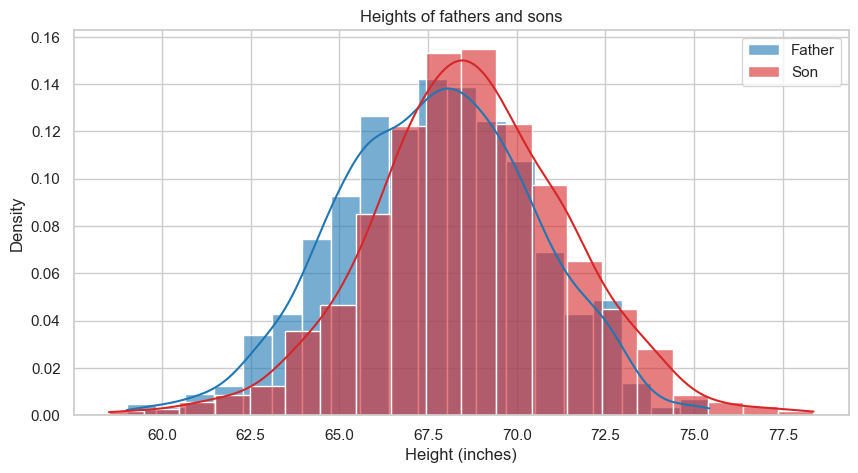

In [89]:
plt.figure(figsize=(10, 5))

sns.histplot(fsdata, x='father', bins=20, color='#1f77b4', kde=True, stat='density', alpha=0.6, label='Father')
sns.histplot(fsdata, x='son', bins=20, color='#d62728', kde=True, stat='density', alpha=0.6, label='Son')

plt.title('Heights of fathers and sons')
plt.xlabel('Height (inches)')
plt.ylabel('Density')
plt.legend()
plt.show()

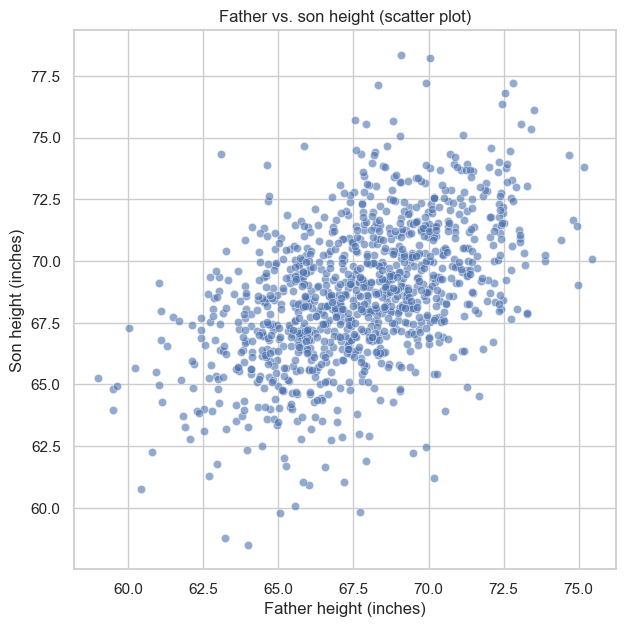

In [90]:
plt.figure(figsize=(7, 7))
sns.scatterplot(data=fsdata, x='father', y='son', alpha=0.6)
plt.title('Father vs. son height (scatter plot)')
plt.xlabel('Father height (inches)')
plt.ylabel('Son height (inches)')
plt.show()

## 4. Recap: t-tests
We revisit two classical tests covered in the lecture.
1. A *paired* t-test to compare father and son means (the observations are naturally paired by family).
2. A one-sample t-test to check whether the average son height exceeds 67 inches.

Both are shown twice: first via manual formulas, then with `scipy` for confirmation.

### 4.1 Paired t-test (sons vs fathers)

In [91]:
diff = fsdata['son'] - fsdata['father']
mean_diff = diff.mean()
sd_diff = diff.std(ddof=1)
n = len(diff)

standard_error = sd_diff / np.sqrt(n)
t_statistic = mean_diff / standard_error
degrees_of_freedom = n - 1

p_value_two_sided = 2 * (1 - stats.t.cdf(abs(t_statistic), df=degrees_of_freedom))

print(f"Mean difference (son - father): {mean_diff:.3f} inches")
print(f"t statistic: {t_statistic:.3f}, df: {degrees_of_freedom}")
print(f"Two-sided p-value: {p_value_two_sided:.4f}")

Mean difference (son - father): 0.997 inches
t statistic: 11.789, df: 1077
Two-sided p-value: 0.0000


In [92]:
scipy_result = stats.ttest_rel(fsdata['son'], fsdata['father'])
print(scipy_result)

TtestResult(statistic=np.float64(11.788549038237012), pvalue=np.float64(2.957226369228171e-30), df=np.int64(1077))


### 4.2 One-sample t-test (is the mean son height > 67 inches?)

In [93]:
mu_0 = 67
sons = fsdata['son']
mean_son = sons.mean()
std_son = sons.std(ddof=1)
n = len(sons)

standard_error = std_son / np.sqrt(n)
t_statistic = (mean_son - mu_0) / standard_error
p_value_one_sided = 1 - stats.t.cdf(t_statistic, df=n - 1)

print(f"Sample mean: {mean_son:.3f} inches")
print(f"t statistic: {t_statistic:.3f}, df: {n - 1}")
print(f"One-sided p-value (H1: mean > 67): {p_value_one_sided:.4f}")

Sample mean: 68.684 inches
t statistic: 19.644, df: 1077
One-sided p-value (H1: mean > 67): 0.0000


In [94]:
scipy_result = stats.ttest_1samp(sons, popmean=mu_0, alternative='greater')
print(scipy_result)

TtestResult(statistic=np.float64(19.644323273595266), pvalue=np.float64(5.6639323832923115e-74), df=np.int64(1077))


## 5. Manual simple linear regression
The lecture derives estimators for the intercept $\hat{\beta}_0$ and slope $\hat{\beta}_1$ of the simple linear regression model
$$ y_i = \beta_0 + \beta_1 x_i + \varepsilon_i. $$

We compute the estimates three different ways and show that they agree:
1. Directly from the sums in the normal equations.
2. Using covariance/variance relationships.
3. Using a linear-algebra formulation (`np.linalg.lstsq`).

In [95]:
Y = fsdata['son'].to_numpy()
X = fsdata['father'].to_numpy()

x_mean = X.mean()
y_mean = Y.mean()

S_xy = ((X - x_mean) * (Y - y_mean)).sum()
S_xx = ((X - x_mean) ** 2).sum()

beta1_from_sums = S_xy / S_xx
beta0_from_sums = y_mean - beta1_from_sums * x_mean

print(f"Beta1 (slope) from sums: {beta1_from_sums:.4f}")
print(f"Beta0 (intercept) from sums: {beta0_from_sums:.4f}")

Beta1 (slope) from sums: 0.5141
Beta0 (intercept) from sums: 33.8866


In [96]:
# Covariance / variance formulation
cov_xy = np.cov(X, Y, ddof=1)[0, 1]
var_x = np.var(X, ddof=1)

beta1_from_cov = cov_xy / var_x
beta0_from_cov = y_mean - beta1_from_cov * x_mean

print(f"Beta1 (slope) from covariance: {beta1_from_cov:.4f}")
print(f"Beta0 (intercept) from covariance: {beta0_from_cov:.4f}")

Beta1 (slope) from covariance: 0.5141
Beta0 (intercept) from covariance: 33.8866


In [97]:
# Linear algebra / least squares solution
X_design = np.column_stack((np.ones_like(X), X))
beta_hat, *_ = np.linalg.lstsq(X_design, Y, rcond=None)

beta0_lstsq, beta1_lstsq = beta_hat
print(f"Beta0 from lstsq: {beta0_lstsq:.4f}")
print(f"Beta1 from lstsq: {beta1_lstsq:.4f}")

Beta0 from lstsq: 33.8866
Beta1 from lstsq: 0.5141


In [98]:
comparison = pd.DataFrame({
    'approach': ['normal equations', 'covariance ratio', 'least squares'],
    'beta0': [beta0_from_sums, beta0_from_cov, beta0_lstsq],
    'beta1': [beta1_from_sums, beta1_from_cov, beta1_lstsq]
})
comparison

,approach,beta0,beta1
0,normal equations,33.887,0.514
1,covariance ratio,33.887,0.514
2,least squares,33.887,0.514



### 5.1 Preview: residuals and sampling variability
These quantities come up when we study sampling distributions of the OLS estimators. For now just note the formulas; we will unpack their meaning in the next lecture.


In [99]:

n = len(X)
IX = np.column_stack([np.ones(n), X])

b0_hat, b1_hat = beta0_from_sums, beta1_from_sums
residuals = Y - (b0_hat + b1_hat * X)

sigma_hat = np.sqrt(np.sum(residuals ** 2) / (n - 2))
S_xx = np.sum((X - x_mean) ** 2)

var_b1 = sigma_hat ** 2 / S_xx
sd_b1 = np.sqrt(var_b1)

var_b0 = sigma_hat ** 2 * (np.sum(X ** 2) / (n * S_xx))
sd_b0 = np.sqrt(var_b0)

summary = pd.Series({
    'sigma_hat (residual sd)': sigma_hat,
    'var(b1_hat)': var_b1,
    'sd(b1_hat)': sd_b1,
    'var(b0_hat)': var_b0,
    'sd(b0_hat)': sd_b0
})
summary


sigma_hat (residual sd)   2.437
var(b1_hat)               0.001
sd(b1_hat)                0.027
var(b0_hat)               3.358
sd(b0_hat)                1.832
dtype: float64


### 5.2 Preview: solving the normal equations with `numpy.linalg`
Here we reproduce the manual slope/intercept using matrix algebra. For the no-intercept model we solve a $1	imes 1$ system; for the standard model we solve the $2	imes 2$ system.


In [100]:

X_no_const = X.reshape(-1, 1)

beta_hat_no_const = np.linalg.solve(X_no_const.T @ X_no_const, X_no_const.T @ Y)
beta_hat_with_const = np.linalg.solve(IX.T @ IX, IX.T @ Y)

pd.DataFrame({
    'model': ['no intercept', 'with intercept'],
    'beta0': [0.0, beta_hat_with_const[0]],
    'beta1': [beta_hat_no_const[0], beta_hat_with_const[1]]
})


,model,beta0,beta1
0,no intercept,0.000,1.014
1,with intercept,33.887,0.514



### 5.3 Preview: `statsmodels` fits (with and without intercept)
The `statsmodels` output will be our workhorse for inference later on. For now, focus on how the coefficients change when we force the line through the origin.


In [101]:

model_no_intercept = sm.OLS(Y, X_no_const).fit()
model_with_intercept = sm.OLS(Y, sm.add_constant(X)).fit()

results_preview = pd.DataFrame({
    'model': ['no intercept', 'with intercept'],
    'beta0': [0.0, model_with_intercept.params[0]],
    'beta1': [model_no_intercept.params[0], model_with_intercept.params[1]],
    'R_squared': [model_no_intercept.rsquared, model_with_intercept.rsquared]
})
results_preview


,model,beta0,beta1,R_squared
0,no intercept,0.000,1.014,0.998
1,with intercept,33.887,0.514,0.251



### 5.4 Preview: comparing regression lines
Notice how the forced-zero line (blue) differs from the fitted intercept line (red), especially for shorter fathers. We will discuss the implications in the follow-up session.


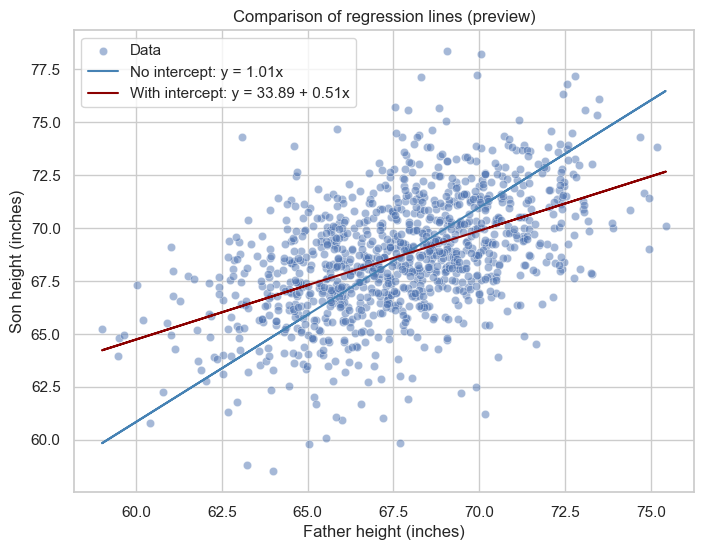

In [102]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X, y=Y, alpha=0.5, label='Data')
plt.plot(X, X * beta_hat_no_const[0], color='steelblue', label=f'No intercept: y = {beta_hat_no_const[0]:.2f}x')
plt.plot(X, model_with_intercept.params[0] + model_with_intercept.params[1] * X,
         color='darkred', label=f'With intercept: y = {model_with_intercept.params[0]:.2f} + {model_with_intercept.params[1]:.2f}x')
plt.xlabel('Father height (inches)')
plt.ylabel('Son height (inches)')
plt.title('Comparison of regression lines (preview)')
plt.legend()
plt.show()



### Optional challenge: what happens with outliers?
Try adding a couple of extreme points and re-running the fits above. How sensitive are the coefficients? (Code scaffold provided if you want to experiment.)


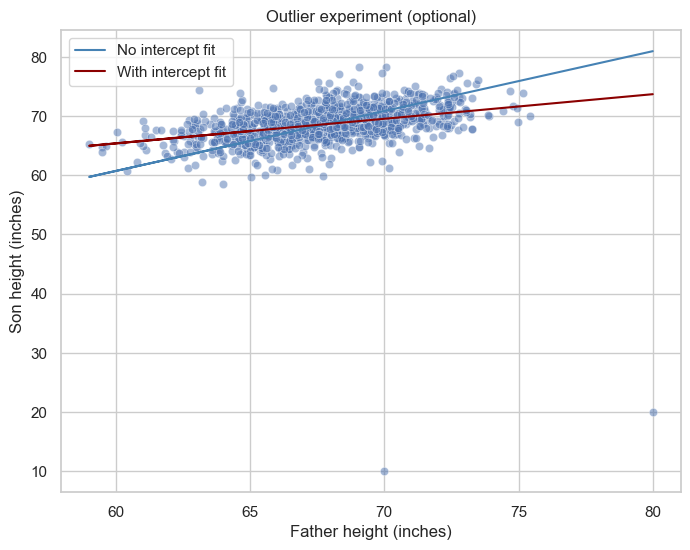

C:\Users\francji1\AppData\Local\Temp\ipykernel_20020\437762279.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta0': [0.0, model_with_intercept_out.params[0]],
C:\Users\francji1\AppData\Local\Temp\ipykernel_20020\437762279.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'beta1': [model_no_intercept_out.params[0], model_with_intercept_out.params[1]]


,model,beta0,beta1
0,no intercept (outliers),0.000,1.012
1,with intercept (outliers),40.445,0.416


In [103]:

fsdata_outliers = fsdata.copy()
outliers = pd.DataFrame({'father': [70, 80], 'son': [10, 20]})
fsdata_outliers = pd.concat([fsdata_outliers, outliers], ignore_index=True)

model_no_intercept_out = smf.ols('son ~ -1 + father', data=fsdata_outliers).fit()
model_with_intercept_out = smf.ols('son ~ father', data=fsdata_outliers).fit()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=fsdata_outliers, x='father', y='son', alpha=0.5)
plt.plot(fsdata_outliers['father'], model_no_intercept_out.fittedvalues, color='steelblue', label='No intercept fit')
plt.plot(fsdata_outliers['father'], model_with_intercept_out.fittedvalues, color='darkred', label='With intercept fit')
plt.xlabel('Father height (inches)')
plt.ylabel('Son height (inches)')
plt.title('Outlier experiment (optional)')
plt.legend()
plt.show()

pd.DataFrame({
    'model': ['no intercept (outliers)', 'with intercept (outliers)'],
    'beta0': [0.0, model_with_intercept_out.params[0]],
    'beta1': [model_no_intercept_out.params[0], model_with_intercept_out.params[1]]
})


## 6. What to remember
- Paired t-tests operate on the differences; a positive mean difference supporting taller sons translates into a large positive t statistic.
- One-sample t-tests compare a sample mean against a benchmark once you set a clear alternative hypothesis.
- The simple regression slope can be derived from sums, from covariance/variance, or by solving the normal equations.
- Preview take-away: forcing the line through the origin changes the slope appreciably; keep this in mind when we study model specification.

## Homework 01 - Cars braking distance
Investigate the relationship between speed and stopping distance using the classic `cars` dataset.

1. Load the dataset (available via `statsmodels` or the shared GitHub URL) and inspect the first few rows.
2. Plot histograms and density curves for `speed` and `dist`, plus the scatter plot.
3. Fit simple linear regression models manually, both with and without an intercept (derive $\hat{\beta}_0$, $\hat{\beta}_1$).
4. Compute the residual sum of squares and the error variance estimate for each model.
5. Derive the variances (and standard errors) of the estimated parameters in both models.
6. Plot the data together with both fitted regression lines on the same axes.
7. Compare the two slopes ? why do they differ? Which model makes more sense for this context?
8. Predict stopping distances at 20 mph and 30 mph using both models; discuss whether those predictions are plausible.
9. Calculate and plot the residuals for both models. Which residual pattern looks healthier?
10. Introduce an artificial outlier (e.g., high distance at low speed) and refit both models. How do the coefficients change?
11. Reflect on whether a straight-line model is an adequate description. Suggest at least two possible next steps (transformations, additional variables, etc.).

In [104]:
# Loading the cars dataset from statsmodels
dataset_cars = sm.datasets.get_rdataset('cars', package='datasets')
cars_df = dataset_cars.data

# Displaying the first few rows of the dataset
cars_df.head()

,speed,dist
0,4,2
1,4,10
2,7,4
3,7,22
4,8,16
